# Test de mes connaissances.

### Imports

In [20]:
import os
import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision.transforms import ToPILImage, ToTensor, RandomRotation
from torch import nn

### Dataset & Dataloaders

In [2]:
path = './RPS/'

transform = torchvision.transforms.Compose([ToTensor()])

full_dataset = torchvision.datasets.ImageFolder(path, transform=transform)

idx_mixed_up = np.random.permutation(len(full_dataset))
idx_train = idx_mixed_up[0:int(0.8*len(full_dataset))]
idx_test = idx_mixed_up[int(0.8*len(full_dataset)):int(0.9*len(full_dataset))]
idx_val = idx_mixed_up[int(0.9*len(full_dataset)):]

train_dataset = Subset(full_dataset, idx_train)
test_dataset = Subset(full_dataset, idx_test)
val_dataset = Subset(full_dataset, idx_val)

print("Taille de full_dataset = ", len(full_dataset))
print("Taille de train_dataset : ", len(train_dataset))
print("Taille de test_dataset : ", len(test_dataset))
print("Taille de val_dataset : ", len(val_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Taille de full_dataset =  2188
Taille de train_dataset :  1750
Taille de test_dataset :  219
Taille de val_dataset :  219


{'paper': 0, 'rock': 1, 'scissors': 2}


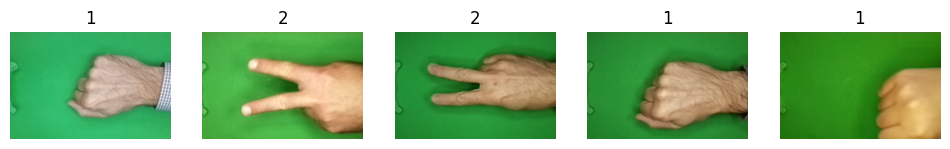

In [3]:
idx = iter(train_dataloader)
fig = plt.figure(figsize=(12,5))
print(full_dataset.class_to_idx)
for i in range(5):
    batch = next(idx)
    img, label = batch[0][i], batch[1][i]
    fig.add_subplot(1,5,i+1), plt.imshow(ToPILImage()(img)), plt.title(label.item()), plt.axis('off')
plt.show()

### Model(s)

In [4]:
# Infos importantes pour le nombre d'inputs et d'outputs parameters
print("Taille de l'image : ", img.shape)

Taille de l'image :  torch.Size([3, 200, 300])


In [12]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.maxpool1 = nn.MaxPool2d(kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(in_features=33744, out_features=2048)
        self.dense2 = nn.Linear(in_features=2048, out_features=4096)
        self.dense3 = nn.Linear(in_features=4096, out_features=3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.maxpool1(self.relu(self.conv1(x)))
        x = self.flatten(self.relu(self.conv2(x)))
        x = self.relu(self.dense1(x))
        x = self.relu(self.dense2(x))
        x = self.dense3(x)
        return x

In [22]:
import torchsummary

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_0 = CNN().to(device)

# Now pass the model to torchsummary
torchsummary.summary(cnn_0, input_size=(3, 200, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 196, 296]             608
              ReLU-2          [-1, 8, 196, 296]               0
         MaxPool2d-3            [-1, 8, 39, 59]               0
            Conv2d-4           [-1, 16, 37, 57]           1,168
              ReLU-5           [-1, 16, 37, 57]               0
           Flatten-6                [-1, 33744]               0
            Linear-7                 [-1, 2048]      69,109,760
              ReLU-8                 [-1, 2048]               0
            Linear-9                 [-1, 4096]       8,392,704
             ReLU-10                 [-1, 4096]               0
           Linear-11                    [-1, 3]          12,291
Total params: 77,516,531
Trainable params: 77,516,531
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.69
Fo

### Entrainement 

In [23]:
LEARNING_RATE = 0.005

cnn_0 = CNN()
optimizer = torch.optim.SGD(cnn_0.parameters(), lr=LEARNING_RATE, weight_decay=0.01)


def train_step(inputs, labels, model, optim, device):
    model.train()
    data = inputs.to(device)
    optim.zero_grad()
    outp = model(data)
    loss = torch.mean(torch.nn.CrossEntropyLoss()(outp.to('cpu'), labels))
    loss.backward()
    optim.step()
    del data
    del outp
    torch.cuda.empty_cache()
    return loss.item()


def eval_step(inputs, labels, model, device):
    model.eval()
    data = inputs.to(device)
    outp = model(data)
    pred = torch.argmax(outp, axis=1)
    acc = torch.mean((labels == pred.to('cpu')).float())
    del data
    del pred
    torch.cuda.empty_cache()
    return acc

In [24]:
NB_EPOCHS = 12
MAX_ITER = 700

avg_loss = []
losses = []
avg_acc = []
acc = []
nb_iter = 0
stop_epoch = False

for epoch in range(NB_EPOCHS):
    for (x_train, y_train) in (train_dataloader):
        nb_iter += 1
        losses.append(train_step(x_train, y_train, cnn_0, optimizer, device=device))

        if nb_iter % 100 == 0:
            avg_loss.append(sum(losses) / len(losses))
            print(" ITER {:d} : Train loss = {:.3f}".format(nb_iter, avg_loss[-1]))
            for (x_val, y_val) in val_dataloader:
                acc.append(eval_step(x_val, y_val, cnn_0, device=device))
            avg_acc.append( sum (acc) / len(acc) )
            print("            Val accuracy = {:.3f}".format(avg_acc[-1]))
            print("---------------------------------")

        if nb_iter > MAX_ITER:
            stop_epoch = True
            break

    if stop_epoch:
        break

 ITER 100 : Train loss = 1.096
            Val accuracy = 0.693
---------------------------------


KeyboardInterrupt: 